In [1]:
import torch
from torch.utils.data import DataLoader
from state_quantization.dataset import load_dataset
from state_quantization.dataset import DynamicsModelDataset
from state_quantization.quantization_models import ForcastingDiscHC, ForcastingDiscHCConst
from state_quantization.train import train_model, test_step
from state_quantization.eval import eval_model, compare_models

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(f"Using Device: {device}")
torch.backends.cudnn.benchmark = True


Using Device: cuda:0


## Load Dataset

In [3]:
dataset_input_key = 'merged_input'
dataset_output_key = 'merged_output'
dataset_file_path = 'tmp/ib-out/ib-samples-la.npy'
normalized_data_params_save_path = 'state_quantization/NormalizeInputConfigs.pkl'
dataset_device = 'cpu'
y_indexes = [4, 6]

train_dataset, val_dataset = load_dataset(file_path=dataset_file_path, input_key=dataset_input_key,
                                          output_key=dataset_output_key, dataset_class=DynamicsModelDataset,
                                          normalize=True, device=dataset_device, y_clip_range=y_indexes,
                                          normalized_data_params_save_path=normalized_data_params_save_path)

batch_size = 500
params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 0,
          'drop_last': True,
          'pin_memory': not train_dataset.x.is_cuda}
print(params)
train_loader = DataLoader(train_dataset, **params)
val_loader = DataLoader(val_dataset, **params)
train_dataset.y[0]

Clipping y
torch.Size([672000, 39, 6])
torch.Size([672000, 10, 2])
torch.Size([288000, 39, 6])
torch.Size([288000, 10, 2])
{'batch_size': 500, 'shuffle': True, 'num_workers': 0, 'drop_last': True, 'pin_memory': True}


tensor([[-0.5183, -0.2843],
        [-0.3589, -0.2480],
        [-0.3227, -0.2709],
        [-0.0018, -0.2999],
        [-0.2396, -0.3225],
        [-0.3146, -0.2979],
        [-0.1600, -0.2786],
        [-0.3053, -0.2695],
        [-0.1568, -0.2845],
        [ 0.2645, -0.3199]])

## Define model

In [4]:
model_dict_path = 'tmp/state_quantization/model_dict'
model_path = 'tmp/state_quantization/model_h_c'
num_of_features = train_dataset.get_features_size()
seq_len = train_dataset.get_seq_len()
hidden_size = 20
out_size = train_dataset.get_output_feature_size()
print(f'Out Size:{out_size}')
look_ahead = train_dataset.get_look_ahead_size()
n_layers = 1
dropout_p = 0.2
print(look_ahead)
model = ForcastingDiscHC(features=num_of_features, hidden_size=hidden_size, out_size=out_size, seq_len=seq_len,
                               n_layers=n_layers, dropout=dropout_p,
                               look_ahead=look_ahead).to(device=device)

load_to_gpu = model.is_cuda() and not train_dataset.x.is_cuda
print(load_to_gpu)

Out Size:2
9
LSTM Layers
ModuleList(
  (0): LSTMCell(6, 20)
)
LSTM Dropout Layers
ModuleList()
Fully Connected Layers
Sequential(
  (0): Linear(in_features=20, out_features=20, bias=True)
  (1): GELU(approximate=none)
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=20, out_features=20, bias=True)
  (4): GELU(approximate=none)
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=20, out_features=2, bias=True)
)
True


## Train Model

In [5]:
train_model(model=model, train_loader=train_loader, test_loader=val_loader, n_epochs=25, learning_rate=1e-3,
            load_to_gpu=load_to_gpu, gamma=0.1, lr_milestones=[4, 9])

Untrained test
--------
Test loss: 1.0006632413715124

Epoch 0
---------
Train loss: 0.22625054757753832
Test loss: 0.11054880561358812
lr: [0.001]
Epoch time: epoch_time = 37.420s
Epoch 1
---------
Train loss: 0.1474450076431302
Test loss: 0.10154985099668717
lr: [0.001]
Epoch time: epoch_time = 35.607s
Epoch 2
---------
Train loss: 0.13989936189526425
Test loss: 0.09636148621535136
lr: [0.001]
Epoch time: epoch_time = 36.723s
Epoch 3
---------
Train loss: 0.13948481976764188
Test loss: 0.09913775988388807
lr: [0.0001]
Epoch time: epoch_time = 37.080s
Epoch 4
---------
Train loss: 0.13702140068857088
Test loss: 0.09712209745258507
lr: [0.0001]
Epoch time: epoch_time = 37.326s
Epoch 5
---------
Train loss: 0.13696449982845002
Test loss: 0.09707698084983146
lr: [0.0001]
Epoch time: epoch_time = 36.496s
Epoch 6
---------
Train loss: 0.13662986179059816
Test loss: 0.09548151362428649
lr: [0.0001]
Epoch time: epoch_time = 37.399s
Epoch 7
---------
Train loss: 0.13611365285413785
Test loss:

## Save Model

In [6]:

torch.save(model.state_dict(), model_dict_path)
torch.save(model, model_path)
torch.cuda.empty_cache()
del model

## Load Model for evaluation

In [7]:

model_classes = [ForcastingDiscHC, ForcastingDiscHCConst]
models = []
for model_class in model_classes:
    models.append(model_class(features=num_of_features, hidden_size=hidden_size, out_size=out_size,
                              seq_len=seq_len, n_layers=n_layers, dropout=dropout_p,
                              look_ahead=look_ahead).to(device))
    models[-1].load_state_dict(torch.load(model_dict_path))

LSTM Layers
ModuleList(
  (0): LSTMCell(6, 20)
)
LSTM Dropout Layers
ModuleList()
Fully Connected Layers
Sequential(
  (0): Linear(in_features=20, out_features=20, bias=True)
  (1): GELU(approximate=none)
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=20, out_features=20, bias=True)
  (4): GELU(approximate=none)
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=20, out_features=2, bias=True)
)
LSTM Layers
ModuleList(
  (0): LSTMCell(6, 20)
)
LSTM Dropout Layers
ModuleList()
Fully Connected Layers
Sequential(
  (0): Linear(in_features=20, out_features=20, bias=True)
  (1): GELU(approximate=none)
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=20, out_features=20, bias=True)
  (4): GELU(approximate=none)
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=20, out_features=2, bias=True)
)


In [8]:
for la_model in models:
    print(la_model.__class__.__name__)
    test_step(model=la_model, data_loader=val_loader, loss_function=torch.nn.MSELoss(), load_to_gpu=load_to_gpu)

ForcastingDiscHC
Test loss: 0.09382477001700965
ForcastingDiscHCConst
Test loss: 0.1491155168817689


LSTM Layers
ModuleList(
  (0): LSTMCell(6, 20)
)
LSTM Dropout Layers
ModuleList()
Fully Connected Layers
Sequential(
  (0): Linear(in_features=20, out_features=20, bias=True)
  (1): GELU(approximate=none)
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=20, out_features=20, bias=True)
  (4): GELU(approximate=none)
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=20, out_features=2, bias=True)
)
LSTM Layers
ModuleList(
  (0): LSTMCell(6, 20)
)
LSTM Dropout Layers
ModuleList()
Fully Connected Layers
Sequential(
  (0): Linear(in_features=20, out_features=20, bias=True)
  (1): GELU(approximate=none)
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=20, out_features=20, bias=True)
  (4): GELU(approximate=none)
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=20, out_features=2, bias=True)
)


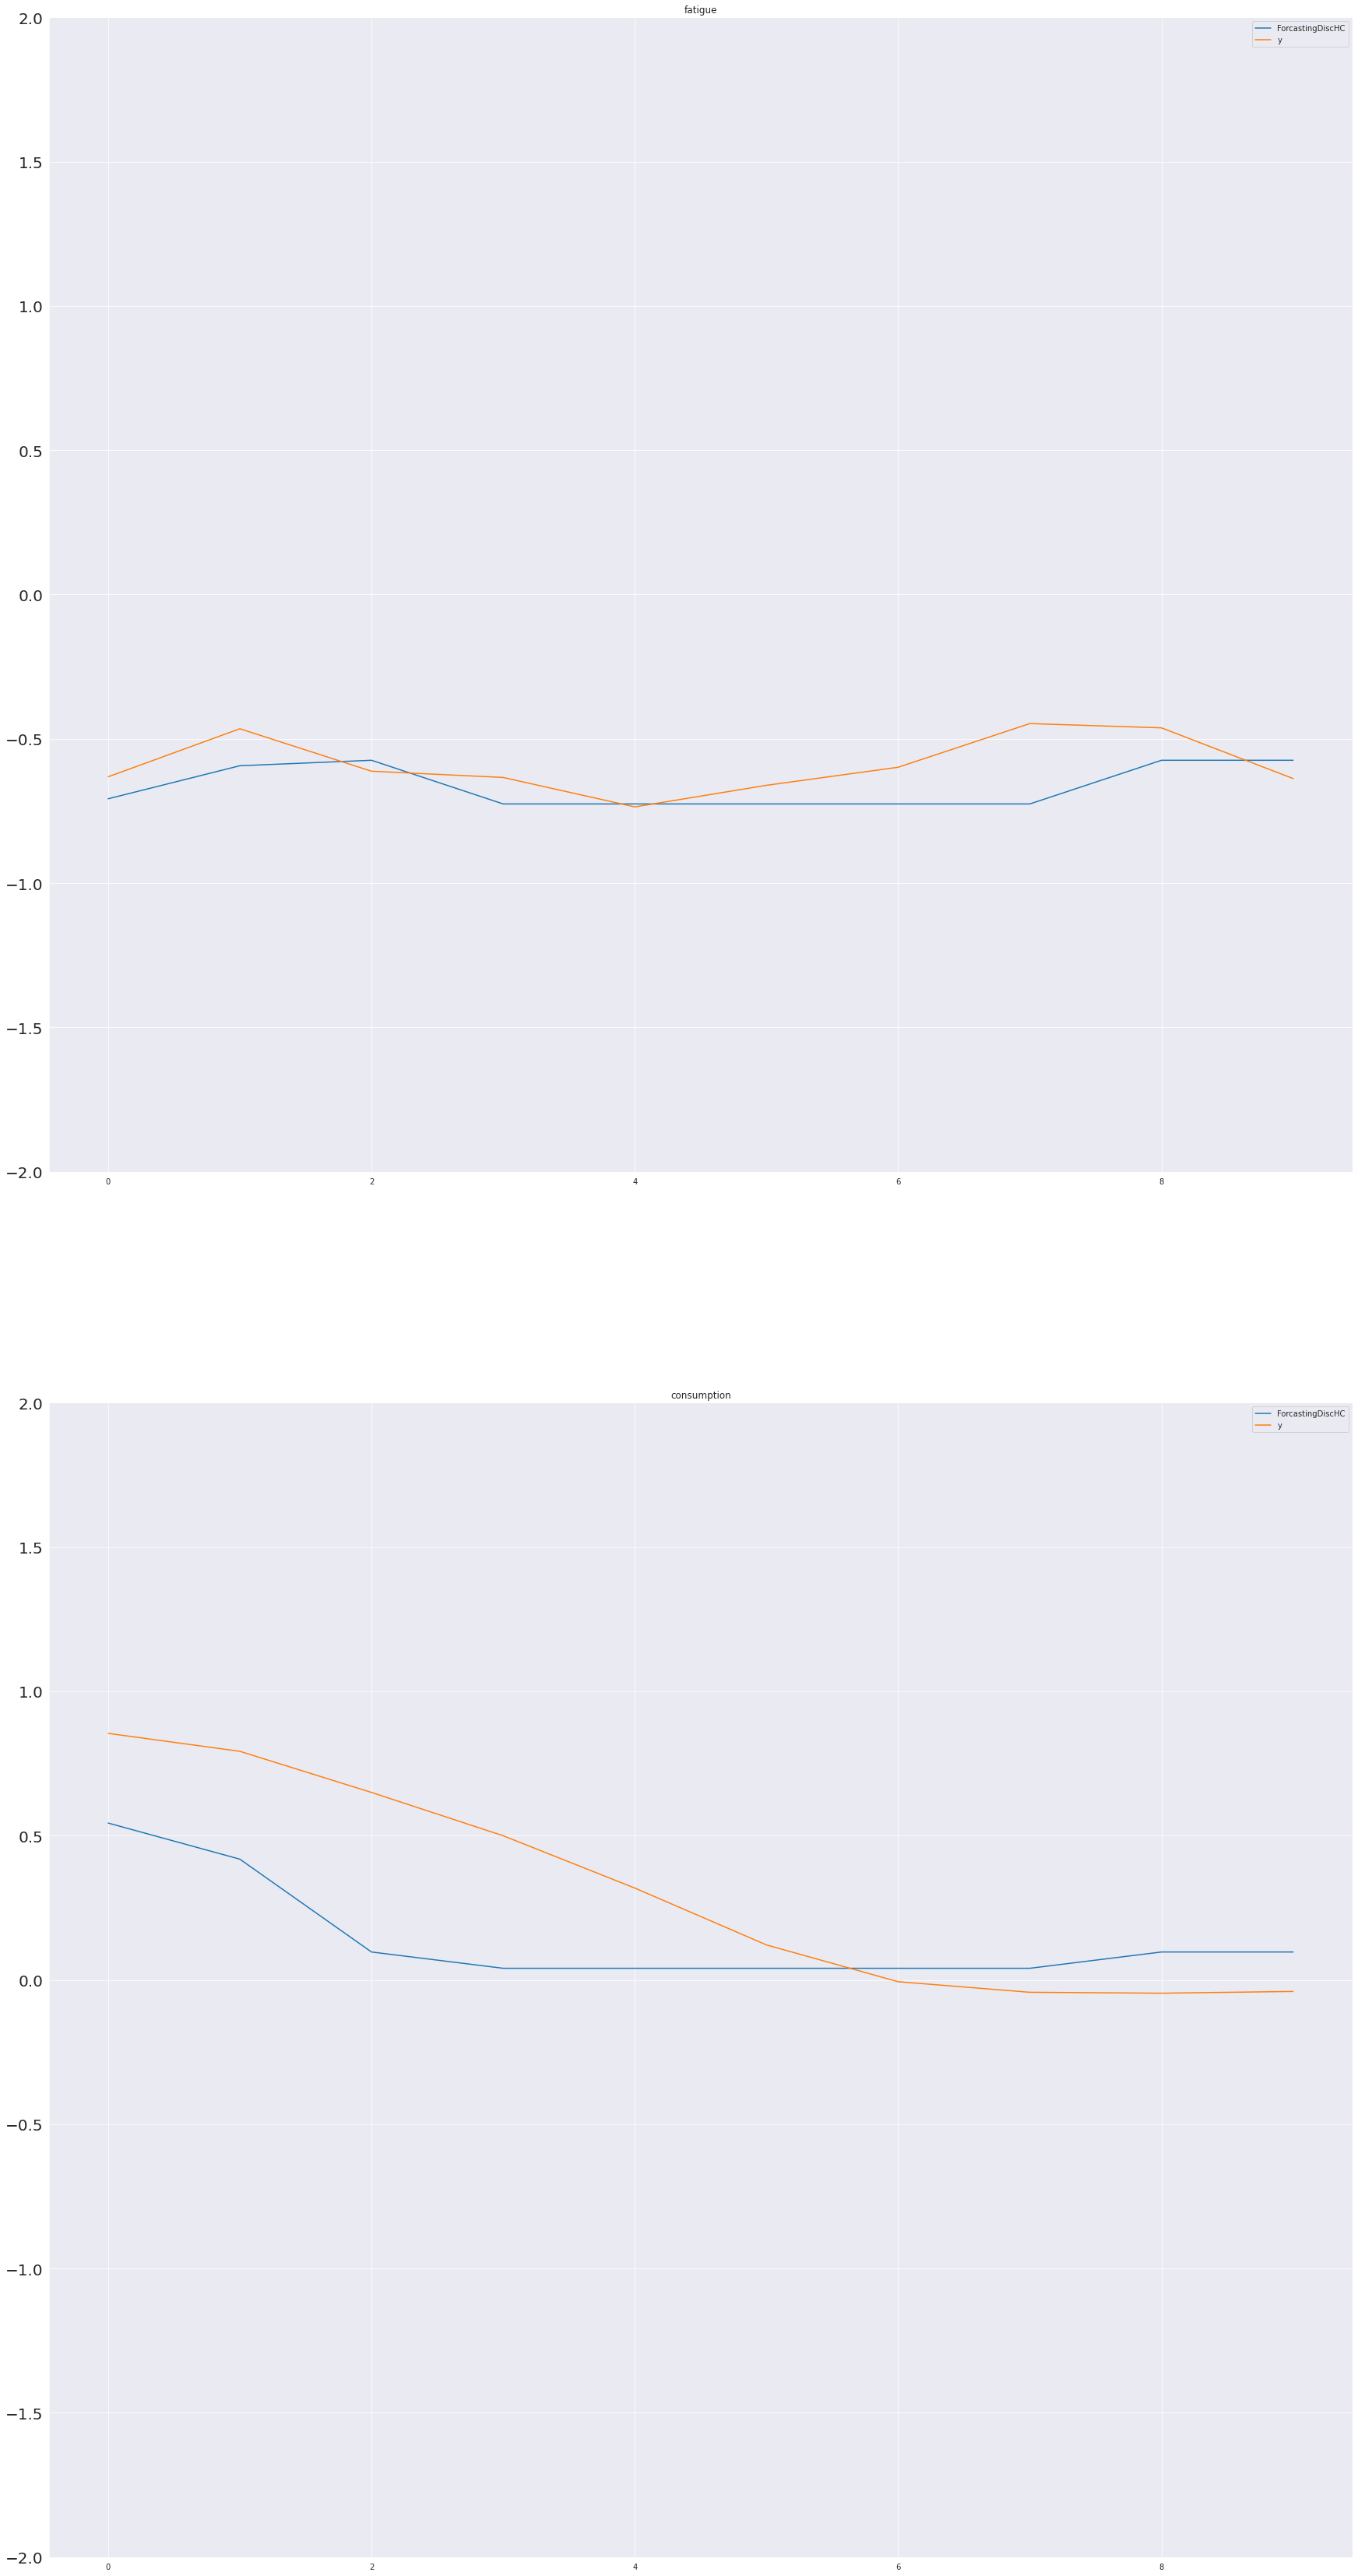

In [9]:
#value_keys = ['setpoint', 'velocity', 'gain', 'shift', 'fatigue', 'consumption']
value_keys = ['fatigue', 'consumption']

models = []
for model_class in model_classes:
    models.append(model_class(features=num_of_features, hidden_size=hidden_size, out_size=out_size,
                              seq_len=seq_len, n_layers=n_layers, dropout=dropout_p,
                              look_ahead=look_ahead).to(dataset_device))
    models[-1].load_state_dict(torch.load(model_dict_path))

compare_models(models[:1], x=val_dataset.x[87], y=val_dataset.y[87], value_keys=value_keys)